In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split

from bikesharing.ml_logic.model import get_folds, train_test_indices
from bikesharing.interface.main import *
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

### Base XGBoost

In [2]:
df_X = pd.read_csv('~/.lewagon/bikesharing/data/processed/X_processed_from_2019_to_2022.csv')
df_y = pd.read_csv('~/.lewagon/bikesharing/data/processed/y_processed_from_2019_to_2022.csv')

In [3]:
df_X_y = pd.concat((df_X, df_y) , axis=1)

In [11]:
districts = ['Altstadt-Lehel', 'Au - Haidhausen',
       'Aubing-Lochhausen-Langwied', 'Berg am Laim', 'Bogenhausen',
       'Feldmoching', 'Hadern', 'Harlaching', 'Hasenbergl-Lerchenau Ost',
       'Laim', 'Lochhausen', 'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt',
       'Milbertshofen-Am Hart', 'Moosach', 'Neuhausen-Nymphenburg',
       'Obergiesing', 'Obermenzing', 'Obersendling', 'Pasing',
       'Pasing-Obermenzing', 'Ramersdorf-Perlach', 'Schwabing-Freimann',
       'Schwabing-West', 'Schwanthalerhöhe', 'Sendling', 'Sendling-Westpark',
       'Südgiesing', 'Thalkirchen', 'Trudering', 'Trudering-Riem',
       'Untergiesing', 'Untergiesing-Harlaching', 'Untermenzing-Allach']

In [12]:
fold_dfs = get_folds(df_X_y, fold_length=FOLD_LENGTH, fold_stride=FOLD_STRIDE)

In [21]:
models = []
district_score_means = []

for dist in districts:
    scores_list = []

    indices = [0, 1, 2, 3]
        
    for id in range(4):
        xgb_r = XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)

        test_df = fold_dfs[id]
        train_folds = [fold_dfs[i] for i in indices if i != id]
        
        train_df = pd.concat(train_folds, axis=0)
        X_test = test_df.drop(columns= districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns= districts)
        y_train = train_df[dist]
        

        
        xgb_r.fit(X_train, y_train)
        y_pred = [x if x >= 0 else 0 for x in xgb_r.predict(X_test)]
        scores = r2_score(y_test , y_pred)
        scores = np.sqrt(mean_squared_error(y_test, xgb_r.predict(X_test)))
        # scores_list.append(scores)
        print(f"{id} >>> scores={scores_list}")
        
        
    scores_array = np.array(scores)
    district_score_means.append(np.mean(scores_array.flatten()))

[10:49:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
0 >>> scores=[]
[10:49:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
1 >>> scores=[]
[10:49:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
2 >>> scores=[]
[10:49:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
3 >>> scores=[]
[10:49:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp

In [23]:
scores_df = pd.DataFrame(district_score_means, columns=['score'], index=districts)

In [24]:
scores_df.sort_values(by=['score'], inplace=True) 

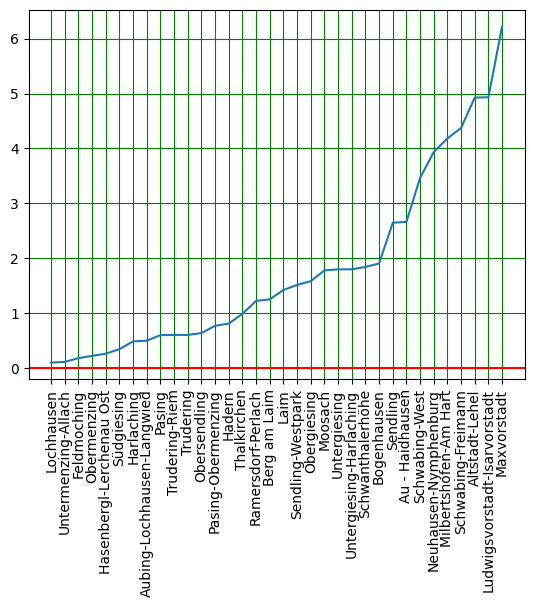

In [25]:
plt.plot(scores_df.index, scores_df['score'])
plt.xticks(rotation=90)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(c='g')


plt.show()

In [26]:
print(f"mean = {np.mean(district_score_means)}")
print(f"min = {np.min(district_score_means)}")
print(f"max = {np.max(district_score_means)}")

mean = 1.7869088466140113
min = 0.1034126158598734
max = 6.217635437812912


### Maxvorstadt

In [14]:
models = []
district_score_means = []
district = 'Maxvorstadt'

xgb_r = XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)

test_df = fold_dfs[0]
train_folds = fold_dfs[1:]
        
train_df = pd.concat(train_folds, axis=0)
X_test = test_df.drop(columns= districts)
y_test = test_df[district]
X_train = train_df.drop(columns= districts)
y_train = train_df[district]
        

        
xgb_r.fit(X_train, y_train)
y_pred = xgb_r.predict(X_test)
#scores = r2_score(y_test , y_pred)
mse_score = np.sqrt(mean_squared_error(y_test, y_pred))

[10:15:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [15]:
print(f'MSE: {mse_score}')

MSE: 6.767914905995791


### Train Test Validation

In [16]:
models = []
district_score_means = []

for dist in districts:
    scores_list = []

    indices = [0, 1, 2, 3]

    for i, item in enumerate(fold_dfs):
        model = XGBRegressor()
        copy_dfs = fold_dfs[:]
        test_df = copy_dfs[i]
        if i <= 2:
            val_df = copy_dfs[i+1]
        else:
            val_df = copy_dfs[0]
        copy_dfs.remove(test_df)
        copy_dfs.remove(val_df)
        train_folds = copy_dfs
        train_df = pd.concat(train_folds, axis=0)
        
        X_test = test_df.drop(columns= districts)
        y_test = test_df[dist]
        X_val = val_df.drop(columns= districts)
        y_val = val_df[dist]
        X_train = train_df.drop(columns= districts)
        y_train = train_df[dist]
        
        
        model.fit(X_train, y_train)
        y_pred = [x if x >= 0 else 0 for x in model.predict(X_test)]
        # scores = r2_score(y_test , y_pred)
        scores = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
        scores_list.append(scores)
        print(f"{id} >>> scores={scores_list}")
        
        
    scores_array = np.array(scores)
    district_score_means.append(np.mean(scores_array.flatten()))

3 >>> scores=[5.335028810492445]


ValueError: Can only compare identically-labeled (both index and columns) DataFrame objects

### R2 Score

In [27]:
models = []
district_score_means = []

for dist in districts:
    scores_list = []

    indices = [0, 1, 2, 3]
        
    for id in range(4):
        xgb_r = XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)

        test_df = fold_dfs[id]
        train_folds = [fold_dfs[i] for i in indices if i != id]
        
        train_df = pd.concat(train_folds, axis=0)
        X_test = test_df.drop(columns= districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns= districts)
        y_train = train_df[dist]
        

        
        xgb_r.fit(X_train, y_train)
        y_pred = [x if x >= 0 else 0 for x in xgb_r.predict(X_test)]
        scores = r2_score(y_test , y_pred)
        #scores = np.sqrt(mean_squared_error(y_test, xgb_r.predict(X_test)))
        scores_list.append(scores)
        print(f"{id} >>> scores={scores_list}")
        
        
    scores_array = np.array(scores)
    district_score_means.append(np.mean(scores_array.flatten()))

[10:49:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
0 >>> scores=[0.683489765987405]
[10:49:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
1 >>> scores=[0.683489765987405, 0.6604730637086313]
[10:49:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
2 >>> scores=[0.683489765987405, 0.6604730637086313, 0.6840394508451091]
[10:49:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg

In [28]:
scores_df = pd.DataFrame(district_score_means, columns=['score'], index=districts)

In [29]:
scores_df.sort_values(by=['score'], inplace=True) 

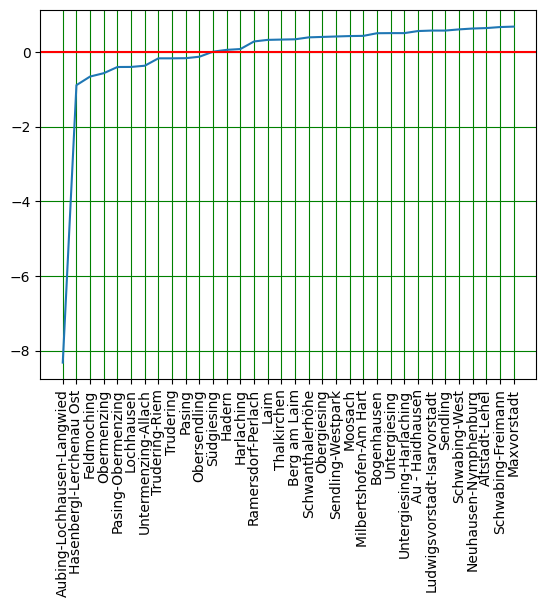

In [30]:
plt.plot(scores_df.index, scores_df['score'])
plt.xticks(rotation=90)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(c='g')

In [31]:
print(f"mean = {np.mean(district_score_means)}")
print(f"min = {np.min(district_score_means)}")
print(f"max = {np.max(district_score_means)}")

mean = -0.068845878085581
min = -8.319359153390305
max = 0.6786202963375587


### Droping few Districts

In [ ]:
# drop_dist = [Aubing-Lochhausen-Langwied
# Harlaching
# Südgiesing
# Hasenbergl-Lerchenau Ost
# Obermenzing
# Feldmoching
# Untermenzing-Allach
# Lochhausen]

In [32]:
districts = ['Altstadt-Lehel', 'Au - Haidhausen',
       'Berg am Laim', 'Bogenhausen',
       'Hadern', 
       'Laim', 'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt',
       'Milbertshofen-Am Hart', 'Moosach', 'Neuhausen-Nymphenburg',
       'Obergiesing', 'Obersendling', 'Pasing',
       'Pasing-Obermenzing', 'Ramersdorf-Perlach', 'Schwabing-Freimann',
       'Schwabing-West', 'Schwanthalerhöhe', 'Sendling', 'Sendling-Westpark',
       'Thalkirchen', 'Trudering', 'Trudering-Riem',
       'Untergiesing', 'Untergiesing-Harlaching']

In [45]:
models = []
district_score_means = []

for dist in districts:
    scores_list = []

    for i, fold in enumerate(fold_dfs):
        folds = fold_dfs[:]
        test_df = folds[i]
        del folds[i]
        train_dfs = folds    
        
        train_df = pd.concat(train_dfs, axis=0)

        X_test = test_df.drop(columns= districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns= districts)
        y_train = train_df[dist]
        
        xgb_r.fit(X_train, y_train)
        y_pred = [x if x >= 0 else 0 for x in xgb_r.predict(X_test)]
        scores = r2_score(y_test , y_pred)
        #scores = np.sqrt(mean_squared_error(y_test, xgb_r.predict(X_test)))
        scores_list.append(scores)
        print(f"{id} >>> scores={scores_list}")
        
        
    scores_array = np.array(scores)
    district_score_means.append(np.mean(scores_array.flatten()))

3 >>> scores=[0.6924460616873617]
3 >>> scores=[0.6924460616873617, 0.6806105442220018]
3 >>> scores=[0.6924460616873617, 0.6806105442220018, 0.6887922386245285]
3 >>> scores=[0.6924460616873617, 0.6806105442220018, 0.6887922386245285, 0.6413558900085552]
3 >>> scores=[0.5649228573967351]
3 >>> scores=[0.5649228573967351, 0.5893110849990493]
3 >>> scores=[0.5649228573967351, 0.5893110849990493, 0.5827073135509688]
3 >>> scores=[0.5649228573967351, 0.5893110849990493, 0.5827073135509688, 0.55087166362109]
3 >>> scores=[0.39554021075307877]
3 >>> scores=[0.39554021075307877, 0.39004251185747263]
3 >>> scores=[0.39554021075307877, 0.39004251185747263, 0.342209356559357]
3 >>> scores=[0.39554021075307877, 0.39004251185747263, 0.342209356559357, 0.3333555370087974]
3 >>> scores=[0.5350438086726624]
3 >>> scores=[0.5350438086726624, 0.5411170138158093]
3 >>> scores=[0.5350438086726624, 0.5411170138158093, 0.5370208198414845]
3 >>> scores=[0.5350438086726624, 0.5411170138158093, 0.53702081984

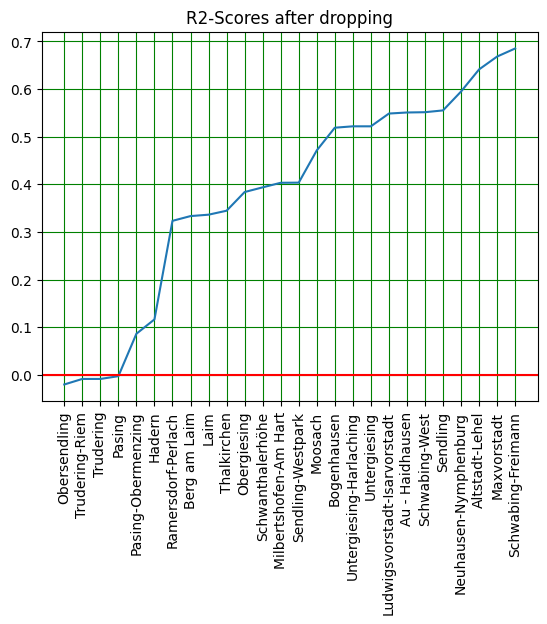

In [46]:
scores_df = pd.DataFrame(district_score_means, columns=['score'], index=districts)

scores_df.sort_values(by=['score'], inplace=True) 

plt.plot(scores_df.index, scores_df['score'])
plt.xticks(rotation=90)
plt.axhline(y=0, color='r', linestyle='-')
plt.title("R2-Scores after dropping")
plt.grid(c='g')

In [38]:
print(f"mean = {np.mean(district_score_means)}")
print(f"min = {np.min(district_score_means)}")
print(f"max = {np.max(district_score_means)}")

mean = 0.38131896250343217
min = -0.020257719642922334
max = 0.685285081517427


### Mean Squared Log Error

In [47]:
models = []
district_score_means = []

for dist in districts:
    scores_list = []

    indices = [0, 1, 2, 3]
        
    for id in range(4):
        xgb_r = XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)

        test_df = fold_dfs[id]
        train_folds = [fold_dfs[i] for i in indices if i != id]
        
        train_df = pd.concat(train_folds, axis=0)
        X_test = test_df.drop(columns= districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns= districts)
        y_train = train_df[dist]
        

        
        xgb_r.fit(X_train, y_train)
        y_pred = [x if x >= 0 else 0 for x in xgb_r.predict(X_test)]
        scores = mean_squared_log_error(y_test , y_pred)
        #scores = np.sqrt(mean_squared_error(y_test, xgb_r.predict(X_test)))
        scores_list.append(scores)
        print(f"{id} >>> scores={scores_list}")
        
        
    scores_array = np.array(scores)
    district_score_means.append(np.mean(scores_array.flatten()))

0 >>> scores=[0.41802149751134554]
1 >>> scores=[0.41802149751134554, 0.46368932815903996]
2 >>> scores=[0.41802149751134554, 0.46368932815903996, 0.38854731180850227]
3 >>> scores=[0.41802149751134554, 0.46368932815903996, 0.38854731180850227, 0.3445698798854083]
0 >>> scores=[0.37649046964334915]
1 >>> scores=[0.37649046964334915, 0.33458240100131775]
2 >>> scores=[0.37649046964334915, 0.33458240100131775, 0.2854818231752432]
3 >>> scores=[0.37649046964334915, 0.33458240100131775, 0.2854818231752432, 0.28882188959482086]
0 >>> scores=[0.24872051816885649]
1 >>> scores=[0.24872051816885649, 0.24930404696148667]
2 >>> scores=[0.24872051816885649, 0.24930404696148667, 0.24526256243065317]
3 >>> scores=[0.24872051816885649, 0.24930404696148667, 0.24526256243065317, 0.24743028327599717]
0 >>> scores=[0.3005126847161238]
1 >>> scores=[0.3005126847161238, 0.29515643238986156]
2 >>> scores=[0.3005126847161238, 0.29515643238986156, 0.2874737580438409]
3 >>> scores=[0.3005126847161238, 0.29515

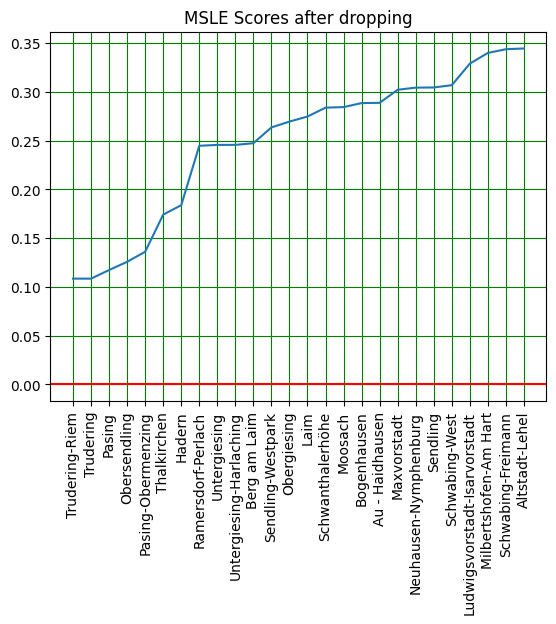

In [48]:
scores_df = pd.DataFrame(district_score_means, columns=['score'], index=districts)

scores_df.sort_values(by=['score'], inplace=True) 

plt.plot(scores_df.index, scores_df['score'])
plt.xticks(rotation=90)
plt.axhline(y=0, color='r', linestyle='-')
plt.title("MSLE Scores after dropping")
plt.grid(c='g')

In [43]:
print(f"mean = {np.mean(district_score_means)}")
print(f"min = {np.min(district_score_means)}")
print(f"max = {np.max(district_score_means)}")

mean = 0.24874230637684405
min = 0.10854809015397099
max = 0.3445698798854083


In [63]:
months = range(1, 13, 1)

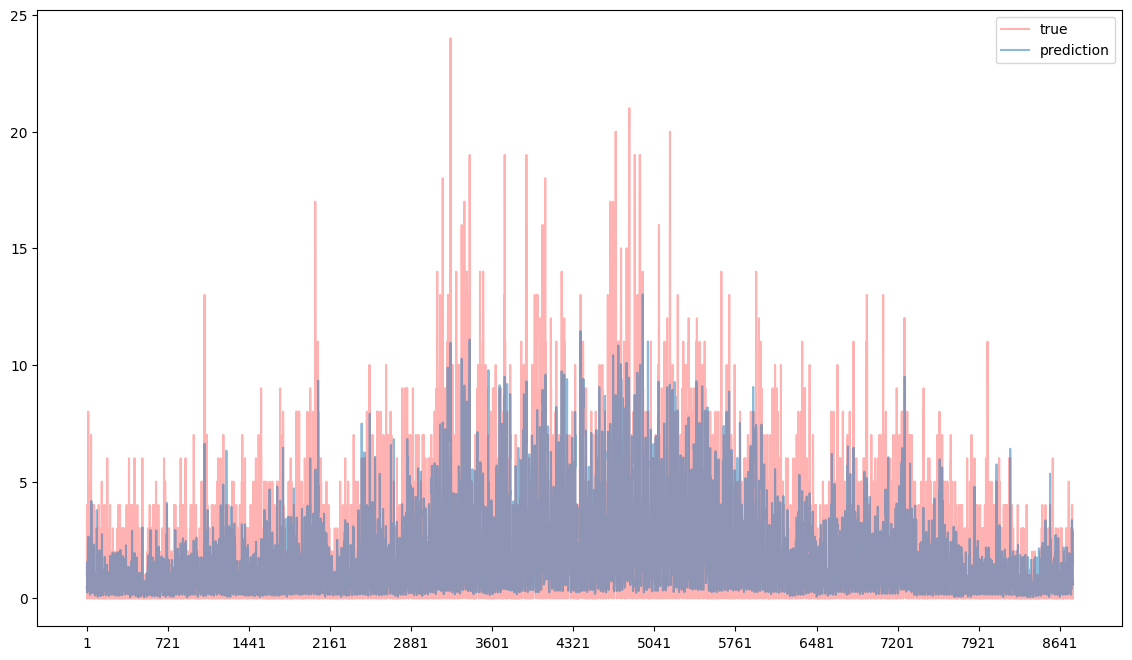

In [76]:
plt.figure(figsize=(14,8))
plt.plot(range(len(y_test)), y_test, c='r', alpha=0.3, label='true')
plt.plot(range(len(y_pred)), y_pred, alpha=0.5, label='prediction')

plt.xticks(np.arange(1, 8769, 720))
plt.legend()


In [80]:
y_test

26280    1.0
26281    1.0
26282    2.0
26283    4.0
26284    3.0
        ... 
35035    2.0
35036    1.0
35037    0.0
35038    1.0
35039    0.0
Name: Untergiesing-Harlaching, Length: 8760, dtype: float64

### Mean number of rent Pred vs True

In [82]:
models = []
district_score_means = []
pred_rent_number = []

for dist in districts:
    scores_list = []
    district_pred = []

    for i, fold in enumerate(fold_dfs):
        folds = fold_dfs[:]
        test_df = folds[i]
        del folds[i]
        train_dfs = folds    
        
        train_df = pd.concat(train_dfs, axis=0)

        X_test = test_df.drop(columns= districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns= districts)
        y_train = train_df[dist]
        
        xgb_r.fit(X_train, y_train)
        y_pred = [x if x >= 0 else 0 for x in xgb_r.predict(X_test)]
        district_pred.append(y_pred)
        scores = r2_score(y_test , y_pred)
        #scores = np.sqrt(mean_squared_error(y_test, xgb_r.predict(X_test)))
        scores_list.append(scores)
        print(f"{id} >>> scores={scores_list}")
        
        
    scores_array = np.array(scores)
    district_score_means.append(np.mean(scores_array.flatten()))
    
    pred_rent_number.append(district_pred)
    

3 >>> scores=[0.6924460616873617]
3 >>> scores=[0.6924460616873617, 0.6806105442220018]
3 >>> scores=[0.6924460616873617, 0.6806105442220018, 0.6887922386245285]
3 >>> scores=[0.6924460616873617, 0.6806105442220018, 0.6887922386245285, 0.6413558900085552]
3 >>> scores=[0.5649228573967351]
3 >>> scores=[0.5649228573967351, 0.5893110849990493]
3 >>> scores=[0.5649228573967351, 0.5893110849990493, 0.5827073135509688]
3 >>> scores=[0.5649228573967351, 0.5893110849990493, 0.5827073135509688, 0.55087166362109]
3 >>> scores=[0.39554021075307877]
3 >>> scores=[0.39554021075307877, 0.39004251185747263]
3 >>> scores=[0.39554021075307877, 0.39004251185747263, 0.342209356559357]
3 >>> scores=[0.39554021075307877, 0.39004251185747263, 0.342209356559357, 0.3333555370087974]
3 >>> scores=[0.5350438086726624]
3 >>> scores=[0.5350438086726624, 0.5411170138158093]
3 >>> scores=[0.5350438086726624, 0.5411170138158093, 0.5370208198414845]
3 >>> scores=[0.5350438086726624, 0.5411170138158093, 0.53702081984

In [95]:
len(pred_rent_number[0])

4

In [96]:
# pred_rent_number[district]
# mean_per_hour = []
#     [fold]
#         [hour]


In [112]:
pred_rent_number_transposed = np.transpose(pred_rent_number, (0, 2, 1))

In [117]:
districts_mean = []
for dist in pred_rent_number_transposed:
    hours_mean = []
    for hour in dist:
        number_per_hour = []
        for fold in hour:
            number_per_hour.append(fold)
        mean_number_per_hour = np.mean(number_per_hour)
        hours_mean.append(mean_number_per_hour)
    districts_mean.append(hours_mean)

In [122]:
len(districts_mean[0])

dist_hours = np.array(districts_mean)
dist_hours_t = np.transpose(dist_hours)

In [130]:
mean_for_all_districts = []

for number in dist_hours_t:
    mean_number = np.mean(number)
    mean_for_all_districts.append(mean_number)

In [131]:
mean_for_all_districts

[0.424582889303565,
 0.47659982192831546,
 0.3244228399931811,
 0.2773856930792905,
 0.2814168316074826,
 0.20360161267364255,
 0.4098587521316054,
 0.8749477821760453,
 1.477144557552842,
 1.3275449253045595,
 1.2424882077253783,
 1.3813639611292343,
 1.8792678581980558,
 1.9275287804551995,
 1.9518617218217025,
 2.0391441552111735,
 2.239448661987598,
 2.0843160908955793,
 2.0516716419504237,
 1.7713003420772462,
 1.210968685730432,
 0.991841989211165,
 0.8585074335838166,
 0.5934098799569676,
 0.5649388203970515,
 0.5389191824226425,
 0.4936539207656796,
 0.38682318682997274,
 0.26937942432526213,
 0.3344421732920007,
 0.3793540821912197,
 0.9705124286791453,
 1.9344107414810703,
 1.5972914370493247,
 1.4907748852498257,
 1.671097664019236,
 1.8845463834273128,
 2.130102415354206,
 2.1114586275070906,
 2.2090544855365386,
 2.369801681632033,
 2.23548475624277,
 2.535658256150782,
 2.2313882172680817,
 1.3410667211103897,
 1.0399857400558317,
 0.9532823263166043,
 0.6943618682428048,

In [132]:
dist_min = np.min(mean_for_all_districts)
dist_max = np.max(mean_for_all_districts)
dist_mean = np.mean(mean_for_all_districts)

In [133]:
print(f"{dist_min=}")
print(f"{dist_max=}")
print(f"{dist_mean=}")

dist_min=0.11548278125925347
dist_max=13.263464574630444
dist_mean=2.7657368053342535


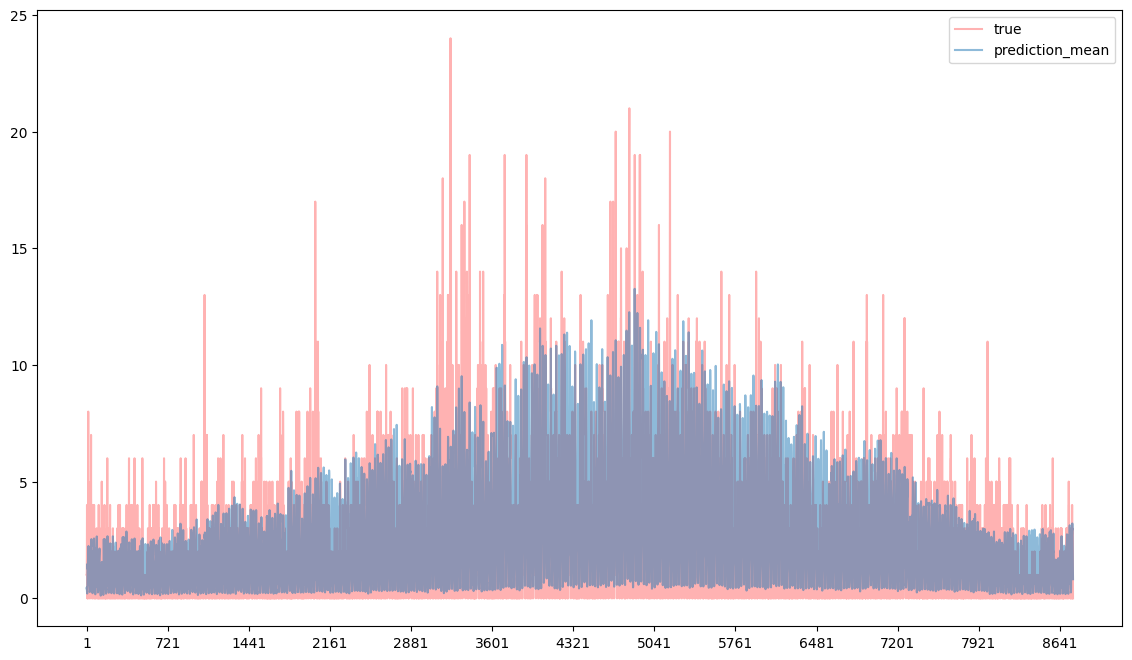

In [134]:
plt.figure(figsize=(14,8))
plt.plot(range(len(y_test)), y_test, c='r', alpha=0.3, label='true')
plt.plot(range(len(y_pred)), mean_for_all_districts, alpha=0.5, label='prediction_mean')

plt.xticks(np.arange(1, 8769, 720))
plt.legend()

### Tuned Features 1 - Robust Scaler

In [142]:
df_X_robust = pd.read_csv('~/.lewagon/bikesharing/data/processed/X_robust_scaler_features.csv')
df_y = pd.read_csv('~/.lewagon/bikesharing/data/processed/y_processed_from_2019_to_2022.csv')

In [143]:
df_X_y_robust = pd.concat((df_X_robust, df_y) , axis=1)

In [144]:
districts = ['Altstadt-Lehel', 'Au - Haidhausen',
       'Berg am Laim', 'Bogenhausen',
       'Hadern', 
       'Laim', 'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt',
       'Milbertshofen-Am Hart', 'Moosach', 'Neuhausen-Nymphenburg',
       'Obergiesing', 'Obersendling', 'Pasing',
       'Pasing-Obermenzing', 'Ramersdorf-Perlach', 'Schwabing-Freimann',
       'Schwabing-West', 'Schwanthalerhöhe', 'Sendling', 'Sendling-Westpark',
       'Thalkirchen', 'Trudering', 'Trudering-Riem',
       'Untergiesing', 'Untergiesing-Harlaching']

In [145]:
fold_dfs_robust = get_folds(df_X_y_robust, fold_length=FOLD_LENGTH, fold_stride=FOLD_STRIDE)

In [149]:
models = []
district_score_means_robust = []

for dist in districts:
    scores_list = []

    for i, fold in enumerate(fold_dfs_robust):
        folds = fold_dfs_robust[:]
        test_df = folds[i]
        del folds[i]
        train_dfs = folds    
        
        train_df = pd.concat(train_dfs, axis=0)

        X_test = test_df.drop(columns= districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns= districts)
        y_train = train_df[dist]
        
        xgb_r.fit(X_train, y_train)
        y_pred = [x if x >= 0 else 0 for x in xgb_r.predict(X_test)]
        scores = r2_score(y_test , y_pred)
        #scores = np.sqrt(mean_squared_error(y_test, xgb_r.predict(X_test)))
        scores_list.append(scores)
        print(f"{id} >>> scores={scores_list}")
        
        
    scores_array = np.array(scores)
    district_score_means_robust.append(np.mean(scores_array.flatten()))

3 >>> scores=[0.6098406967239935]
3 >>> scores=[0.6098406967239935, 0.6564732001788692]
3 >>> scores=[0.6098406967239935, 0.6564732001788692, 0.6792687284798749]
3 >>> scores=[0.6098406967239935, 0.6564732001788692, 0.6792687284798749, 0.639818775559677]
3 >>> scores=[0.5233353268819927]
3 >>> scores=[0.5233353268819927, 0.5833307773542786]
3 >>> scores=[0.5233353268819927, 0.5833307773542786, 0.5953626095803208]
3 >>> scores=[0.5233353268819927, 0.5833307773542786, 0.5953626095803208, 0.5453547714579559]
3 >>> scores=[0.38206804299026087]
3 >>> scores=[0.38206804299026087, 0.3756428724699674]
3 >>> scores=[0.38206804299026087, 0.3756428724699674, 0.3283721592048322]
3 >>> scores=[0.38206804299026087, 0.3756428724699674, 0.3283721592048322, 0.32413701561657904]
3 >>> scores=[0.5297574071961023]
3 >>> scores=[0.5297574071961023, 0.5358516822551714]
3 >>> scores=[0.5297574071961023, 0.5358516822551714, 0.5348799582663293]
3 >>> scores=[0.5297574071961023, 0.5358516822551714, 0.5348799582

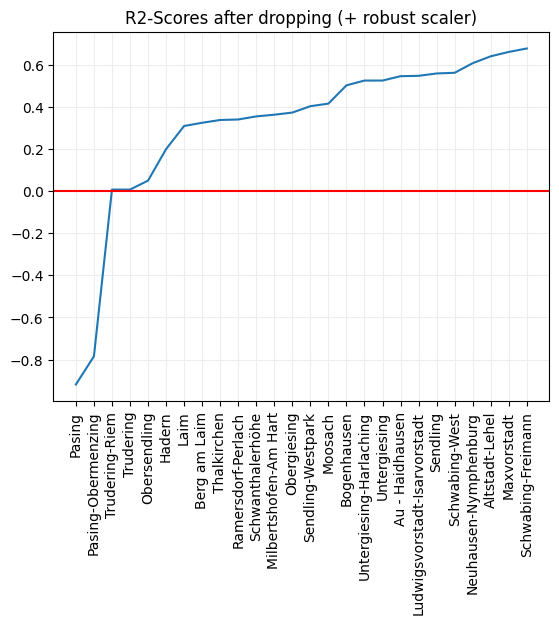

In [154]:
scores_df_robust = pd.DataFrame(district_score_means_robust, columns=['score'], index=districts)

scores_df_robust.sort_values(by=['score'], inplace=True) 

plt.plot(scores_df_robust.index, scores_df_robust['score'])
plt.xticks(rotation=90)
plt.axhline(y=0, color='r', linestyle='-')
plt.title("R2-Scores after dropping (+ robust scaler)")
plt.grid(c='#ededed')

### TestFixed 2022, Train 2019 - 2021

In [155]:
df_X = pd.read_csv('~/.lewagon/bikesharing/data/processed/X_processed_from_2019_to_2022.csv')
df_y = pd.read_csv('~/.lewagon/bikesharing/data/processed/y_processed_from_2019_to_2022.csv')

In [158]:
df_X_y_TF = pd.concat((df_X, df_y) , axis=1)

In [159]:
districts = ['Altstadt-Lehel', 'Au - Haidhausen',
       'Berg am Laim', 'Bogenhausen',
       'Hadern', 
       'Laim', 'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt',
       'Milbertshofen-Am Hart', 'Moosach', 'Neuhausen-Nymphenburg',
       'Obergiesing', 'Obersendling', 'Pasing',
       'Pasing-Obermenzing', 'Ramersdorf-Perlach', 'Schwabing-Freimann',
       'Schwabing-West', 'Schwanthalerhöhe', 'Sendling', 'Sendling-Westpark',
       'Thalkirchen', 'Trudering', 'Trudering-Riem',
       'Untergiesing', 'Untergiesing-Harlaching']

In [160]:
fold_dfs_TF = get_folds(df_X_y, fold_length=FOLD_LENGTH, fold_stride=FOLD_STRIDE)

In [173]:


district_score_means = []

for dist in districts:
    scores_list = []
    
    folds = fold_dfs_TF[:]
    test_df = folds[3]      # TestFixed => Test_Set is always 2022
    del folds[3]

    for i, fold in enumerate(folds):   
        folds.append(folds.pop(i))
        train_df = pd.concat(folds, axis=0)

        X_test = test_df.drop(columns=districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns=districts)
        y_train = train_df[dist]
        
        xgb_r.fit(X_train, y_train)
        y_pred = [x if x >= 0 else 0 for x in xgb_r.predict(X_test)]
        # scores = r2_score(y_test, y_pred)
        scores = mean_squared_log_error(y_test , y_pred)        
        scores_list.append(scores)
        print(f"{dist} >>> scores={scores_list}")
        
        
    scores_array = np.array(scores_list)
    district_score_means.append(np.mean(scores_array.flatten()))


Altstadt-Lehel >>> scores=[0.3445698798854083]
Altstadt-Lehel >>> scores=[0.3445698798854083, 0.3445698798854083]
Altstadt-Lehel >>> scores=[0.3445698798854083, 0.3445698798854083, 0.3445698798854083]
Au - Haidhausen >>> scores=[0.28882188959482086]
Au - Haidhausen >>> scores=[0.28882188959482086, 0.28882188959482086]
Au - Haidhausen >>> scores=[0.28882188959482086, 0.28882188959482086, 0.28882188959482086]
Berg am Laim >>> scores=[0.24743028327599717]
Berg am Laim >>> scores=[0.24743028327599717, 0.24743028327599717]
Berg am Laim >>> scores=[0.24743028327599717, 0.24743028327599717, 0.24743028327599717]
Bogenhausen >>> scores=[0.2885699209811737]
Bogenhausen >>> scores=[0.2885699209811737, 0.2885699209811737]
Bogenhausen >>> scores=[0.2885699209811737, 0.2885699209811737, 0.2885699209811737]
Hadern >>> scores=[0.18385934712218177]
Hadern >>> scores=[0.18385934712218177, 0.18385934712218177]
Hadern >>> scores=[0.18385934712218177, 0.18385934712218177, 0.18385934712218177]
Laim >>> scor

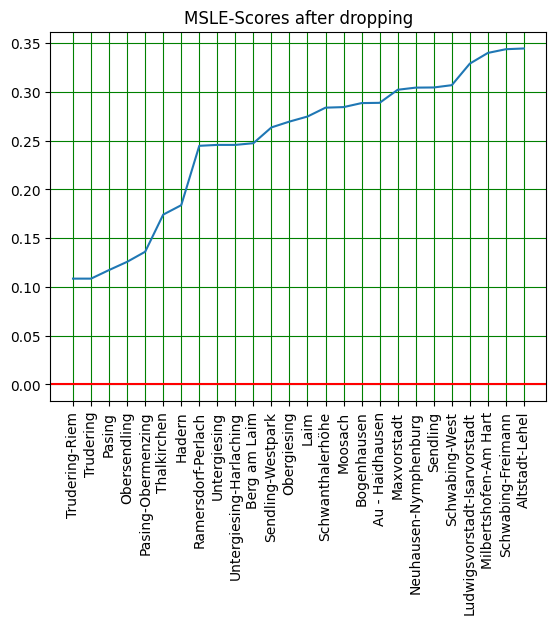

In [174]:
scores_df = pd.DataFrame(district_score_means, columns=['score'], index=districts)

scores_df.sort_values(by=['score'], inplace=True) 

plt.plot(scores_df.index, scores_df['score'])
plt.xticks(rotation=90)
plt.axhline(y=0, color='r', linestyle='-')
plt.title("MSLE-Scores after dropping")
plt.grid(c='g')

In [175]:
print(f"mean = {np.mean(district_score_means)}")
print(f"min = {np.min(district_score_means)}")
print(f"max = {np.max(district_score_means)}")

mean = 0.24874230637684405
min = 0.10854809015397099
max = 0.34456987988540827


### Grid Search

In [190]:
df_X = pd.read_csv('~/.lewagon/bikesharing/data/processed/X_processed_from_2019_to_2022.csv')
df_y = pd.read_csv('~/.lewagon/bikesharing/data/processed/y_processed_from_2019_to_2022.csv')

In [194]:
columns = list(df_y.columns)

In [191]:
df_X_y = pd.concat((df_X, df_y) , axis=1)

In [189]:
fold_dfs = get_folds(df_X_y, fold_length=FOLD_LENGTH, fold_stride=FOLD_STRIDE)

In [206]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV


models = []
district_score_means = []


folds = fold_dfs[:]

test_df = folds[3]
del folds[3]
train_dfs = folds
train_dfs = pd.concat(train_dfs, axis=0)

X_test = test_df.drop(columns= columns)
y_test = test_df['Maxvorstadt']
X_train = train_df.drop(columns= columns)
y_train = train_df['Maxvorstadt']


# Instantiate model
model = XGBRegressor(objective ='reg:squarederror')

params = {
    # Parameters that we are going to tune.
    'max_depth':range(3,10,2),
    'min_child_weight': range(1, 6, 1),
    'eta':[0.1, 0.01, 0.05],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0.5, 1, 1.5, 2, 5]
}

# Instantiate Grid Search
search = GridSearchCV(
    model,
    param_grid=params, 
    scoring = 'neg_mean_squared_error',
    cv = 5,
    n_jobs=-1 # parallelize computation
) 

# Fit data to Grid Search
search.fit(X_train, y_train);

In [207]:
# Best score
print("Best score: ", search.best_score_)

# Best Params
print("Best params: ", search.best_params_)

# Best estimator
search.best_estimator_

Best score:  -39.57116688569175
Best params:  {'colsample_bytree': 1.0, 'eta': 0.05, 'gamma': 1, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.8}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=4, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)